In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np



<ipython-input-2-cba175ade905>:90: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else torch.amp.GradScaler()
<ipython-input-2-cba175ade905>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 1/10 | Loss: 1.0422 | Train Acc: 54.33% | Val Acc: 60.94% | Val F1-score: 0.6038


<ipython-input-2-cba175ade905>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 2/10 | Loss: 0.6112 | Train Acc: 76.17% | Val Acc: 66.31% | Val F1-score: 0.6496


<ipython-input-2-cba175ade905>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 3/10 | Loss: 0.4405 | Train Acc: 83.29% | Val Acc: 67.69% | Val F1-score: 0.6630


<ipython-input-2-cba175ade905>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 4/10 | Loss: 0.3174 | Train Acc: 88.35% | Val Acc: 70.38% | Val F1-score: 0.7063


<ipython-input-2-cba175ade905>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 5/10 | Loss: 0.2330 | Train Acc: 91.46% | Val Acc: 73.12% | Val F1-score: 0.7324


<ipython-input-2-cba175ade905>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 6/10 | Loss: 0.1720 | Train Acc: 93.56% | Val Acc: 71.44% | Val F1-score: 0.7094


<ipython-input-2-cba175ade905>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 7/10 | Loss: 0.1258 | Train Acc: 95.25% | Val Acc: 69.25% | Val F1-score: 0.6882


<ipython-input-2-cba175ade905>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 8/10 | Loss: 0.0880 | Train Acc: 97.02% | Val Acc: 70.00% | Val F1-score: 0.6951


<ipython-input-2-cba175ade905>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 9/10 | Loss: 0.0602 | Train Acc: 97.73% | Val Acc: 72.81% | Val F1-score: 0.7222


<ipython-input-2-cba175ade905>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 10/10 | Loss: 0.0543 | Train Acc: 98.27% | Val Acc: 72.56% | Val F1-score: 0.7227


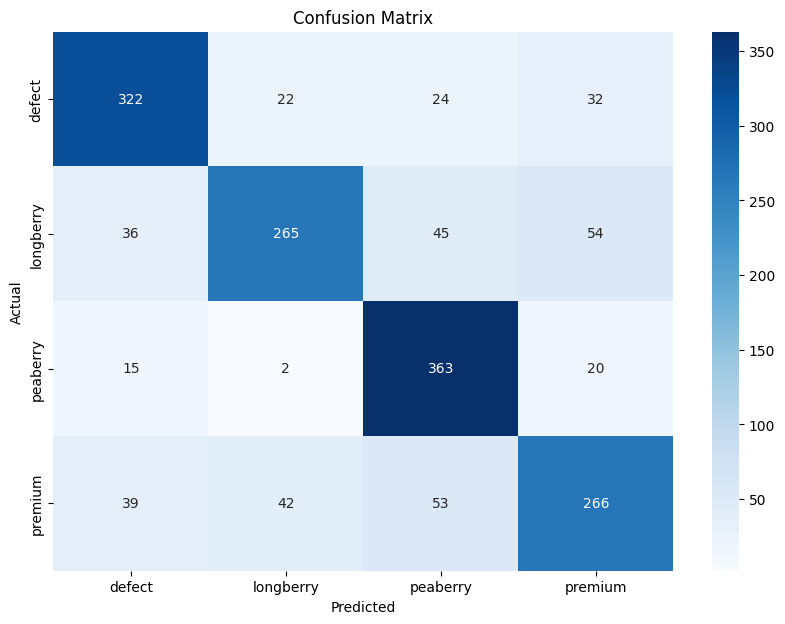


Final Test Accuracy: 76.00% | Final Test F1-score: 0.7569


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np


# Set device (cuda if available, else cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data with Optimized Transformations
def get_dataloader(batch_size=16):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize the images to 128x128
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/USK-Coffee/train', transform=transform)
    test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/USK-Coffee/test', transform=transform)
    val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/USK-Coffee/val', transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader

train_loader, test_loader, val_loader = get_dataloader()

# Define Semantic Convolutional Neural Network (SCNN)
class SemanticCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SemanticCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjusted for 128x128 input size
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

student_model = SemanticCNN().to(device)

# Apply Sparsity
def apply_sparsity(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            prune.l1_unstructured(module, name="weight", amount=amount)
    return model

apply_sparsity(student_model)

# Compute Accuracy, F1 Score & Confusion Matrix
def compute_metrics(model, dataloader, class_names, plot_cm=False):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    if plot_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    return accuracy, f1

# Train Model with Mixed Precision Optimization
def train_model(student, train_loader, val_loader, test_loader, epochs=10, lr=0.001, class_names=[]):
    student.train()
    optimizer = optim.Adam(student.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else torch.amp.GradScaler()

    for epoch in range(epochs):
        total_loss = 0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():  # Mixed precision
                student_outputs = student(images)
                loss = loss_fn(student_outputs, labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

            _, predicted = torch.max(student_outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_acc = 100 * correct_train / total_train
        val_acc, val_f1 = compute_metrics(student, val_loader, class_names)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val F1-score: {val_f1:.4f}")

    test_acc, test_f1 = compute_metrics(student, test_loader, class_names, plot_cm=True)
    print(f"\nFinal Test Accuracy: {test_acc:.2f}% | Final Test F1-score: {test_f1:.4f}")

# Get class names from dataset
class_names = train_loader.dataset.classes

# Train the student model
train_model(student_model, train_loader, val_loader, test_loader, class_names=class_names)
